In [0]:
################################################################################
# Team members: Koushik Modugu, Abhishek Deshmukh, Adithya V Ganesan, Manoj Kumar
# Code Description: This file performs data analysis between crimes in Chicago with various other supplementing 
# information such as unemployment, Income and housing data from Chicago. We furthiur perform hypothesis testing to 
# understand the significance of the correlation.
# Piplines Used: HDFS,PySpark 
# Concepts Used : Hypothesis Testing
# System: Single node Hadoop with spark setup in in local 
################################################################################

In [0]:
import os
import findspark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-preview2-bin-hadoop3.2"
findspark.init()

In [0]:
import pandas as pd
from pyspark import SparkContext, SparkConf
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql import SparkSession
from operator import add
import numpy as np
import math
from scipy import stats
import json
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
%matplotlib inline
from pyspark.sql.window import Window
plt.style.use('seaborn-whitegrid')

In [0]:
spark = SparkSession.builder \
                    .appName("Chicago") \
                    .config("spark.driver.memory", "20g") \
                    .getOrCreate()

In [8]:
# get chicago arrest data from the json files
arrest_df = spark.read.json("hdfs://Crimes_-_2001_to_present0.json")
for i in range(1, 10):
    arrest_df = arrest_df.union(spark.read.json("hdfs://Crimes_-_2001_to_present"+str(i)+".json"))
#format based on timestamp
arrest_df = arrest_df.withColumn("Date", F.from_unixtime(F.unix_timestamp("Date",'MM/dd/yyyy hh:mm:ss a')))
arrest_df = arrest_df.withColumn("Updated On", F.from_unixtime(F.unix_timestamp("Updated On",'MM/dd/yyyy hh:mm:ss a')))
#filter data based on arrest
actual_arrest_df = arrest_df.filter(arrest_df.Arrest==1)
arrest_df.head(4)

[Row(Arrest=False, Beat=412, Block='016XX E 86TH PL', Case Number='JA366925', Community Area=45.0, Date='2001-01-01 11:00:00', Description='FINANCIAL IDENTITY THEFT OVER $ 300', District=4.0, Domestic=False, FBI Code='11', ID=11034701, IUCR='1153', Latitude=None, Location=None, Location Description='RESIDENCE', Longitude=None, Primary_Type_ARSON=0, Primary_Type_ASSAULT=0, Primary_Type_BATTERY=0, Primary_Type_BURGLARY=0, Primary_Type_CONCEALED CARRY LICENSE VIOLATION=0, Primary_Type_CRIM SEXUAL ASSAULT=0, Primary_Type_CRIMINAL DAMAGE=0, Primary_Type_CRIMINAL SEXUAL ASSAULT=0, Primary_Type_CRIMINAL TRESPASS=0, Primary_Type_DECEPTIVE PRACTICE=1, Primary_Type_DOMESTIC VIOLENCE=0, Primary_Type_GAMBLING=0, Primary_Type_HOMICIDE=0, Primary_Type_HUMAN TRAFFICKING=0, Primary_Type_INTERFERENCE WITH PUBLIC OFFICER=0, Primary_Type_INTIMIDATION=0, Primary_Type_KIDNAPPING=0, Primary_Type_LIQUOR LAW VIOLATION=0, Primary_Type_MOTOR VEHICLE THEFT=0, Primary_Type_NARCOTICS=0, Primary_Type_NON - CRIMINAL

# Crime and Unemployment Data Analysis

In [9]:
#get unemployment data
unemp_df = spark.read.csv('/content/drive/My Drive/ChicagoUnemployment.csv',header=True)
unemp_df = unemp_df.withColumnRenamed("Value", "UnemploymentRate")
unemp_df = unemp_df.filter(unemp_df.Year > 2010)
#format based on timestamp
unemp_df = unemp_df.withColumn("Label", F.from_unixtime(F.unix_timestamp("Label",'yyyy MMM')))
unemp_df = unemp_df.withColumn('month', F.substring(unemp_df['Period'],2,2).cast(IntegerType()))
unemp_df = unemp_df.withColumn('UnemploymentRate', unemp_df['UnemploymentRate'].cast(DoubleType()))
unemp_df.head(4)

[Row(Series ID='LAUCT171400000000003', Year='2011', Period='M01', Label='2011-01-01 00:00:00', UnemploymentRate=10.9, 1-Month Net Change='0.8', month=1),
 Row(Series ID='LAUCT171400000000003', Year='2011', Period='M02', Label='2011-02-01 00:00:00', UnemploymentRate=10.6, 1-Month Net Change='-0.3', month=2),
 Row(Series ID='LAUCT171400000000003', Year='2011', Period='M03', Label='2011-03-01 00:00:00', UnemploymentRate=10.3, 1-Month Net Change='-0.3', month=3),
 Row(Series ID='LAUCT171400000000003', Year='2011', Period='M04', Label='2011-04-01 00:00:00', UnemploymentRate=10.3, 1-Month Net Change='0.0', month=4)]

In [0]:
# actual_arrest_df = arrest_df.filter(arrest_df.Arrest==1)
# get aggregated count
grouped_arrests = actual_arrest_df.groupBy([F.month('Date').alias('month'),F.year('Date').alias('year')]).\
          agg(F.count('Arrest').alias('Case Count'))
# join the arrest and the unemployment data
grouped_arrests_unemp = grouped_arrests.join(unemp_df, (grouped_arrests.month ==\
                        unemp_df.month) & (grouped_arrests.year == unemp_df.Year))
grouped_arrests_unemp = grouped_arrests_unemp.select(['Case Count', 'UnemploymentRate'])

from pyspark.ml.feature import VectorAssembler
# All UnemploymentRate into a vector "features"
vectorAssembler = VectorAssembler(inputCols = ['UnemploymentRate'], outputCol = 'features')
vgrouped_arrests_unemp = vectorAssembler.transform(grouped_arrests_unemp)

In [11]:
grouped_arrests_unemp.corr('Case Count', 'UnemploymentRate')

0.8867618828247041

The correlation between UnemploymentRate and NumberOfArrests is 0.88 when the data after 2010 is considered. Interestingly, if we consider data since 2001, the correlation turns out to be 0.24, which implies that from 2001-2010, there were other factors at play. For example, **unemployment rate raised from 2008-2010 due to recession and proportional fraction of the unemployed didn't resort to crime to meet the ends.**

In [0]:
def compute_std_error(x_j_diff_square, rss, df):
    return math.pow(rss/(df*x_j_diff_square), 0.5)

def eval_p_value(t_value, df):
    result = []
    for val in t_value:
        if val > 0.5:
            result.append(2*(1 - stats.t.cdf(val,df=df)))
        else:
            result.append(2*stats.t.cdf(val,df=df))
    return result

def check_slope_significance(p_values, bonferroni_corrected_alpha):
    return_list = list()
    # if True (p_value > bonferroni_corrected_alpha), accept the null hypothesis that the slope is insignificant
    for p_value in p_values:
        return_list.append(True if p_value > bonferroni_corrected_alpha else False)
    return return_list

def slope_significance_hyp_testing(X, y, y_pred, coefficients):
    df = len(X) - (len(coefficients) + 1)
    rss = np.sum((y_pred-y)**2)
    x_j_diff_squares = np.sum((X-np.mean(X, axis=0).reshape(1,-1))**2, axis=0)
    standard_error = compute_std_error(x_j_diff_squares, rss, df)
    t_vals = np.divide(coefficients, standard_error)
    # Testing significance of all coefficients of X, so correction is division by no of hypotheses 
    bonferroni_corrected_alpha = 0.05/len(coefficients)
    p_values = eval_p_value(t_vals, df)
    # print(t_vals, df, p_values)
    significant_coeffs = check_slope_significance(p_values, bonferroni_corrected_alpha)
    return significant_coeffs

In [13]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='Case Count',
                      maxIter=200, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(vgrouped_arrests_unemp)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)
vgrouped_arrests_unemp.describe().show()
lr_predictions = lr_model.transform(vgrouped_arrests_unemp)
output = np.array(lr_predictions.select("prediction","Case Count","UnemploymentRate").collect())
X, y, y_pred = output[:, 2].reshape(-1, 1), output[:, 1].reshape(-1, 1), output[:,0].reshape(-1, 1)
coefficient_significance = slope_significance_hyp_testing(X, y, y_pred, np.array(lr_model.coefficients).reshape(-1,1))
if coefficient_significance[0] is True:
    print("Accepting the Null hypothesis that the coefficient of UnemploymentRate in \
NumberOfArrests prediction is insignificant. UnemploymentRate isn't \
a good predictor of NumberOfArrests")
else:
    print("Rejecting the Null hypothesis that the coefficient of UnemploymentRate in \
NumberOfArrests prediction is insignificant. UnemploymentRate is actually \
a good predictor of NumberOfArrests")

Coefficients: [542.6552817943833]
Intercept: 1945.8744869439072
RMSE: 706.484635
r2: 0.786347
+-------+------------------+-----------------+
|summary|        Case Count| UnemploymentRate|
+-------+------------------+-----------------+
|  count|               111|              111|
|   mean| 5839.792792792793|7.175675675675676|
| stddev|1535.3696926273135|2.508430013020322|
|    min|              2942|              3.1|
|    max|              9038|             11.7|
+-------+------------------+-----------------+

Rejecting the Null hypothesis that the coefficient of UnemploymentRate in NumberOfArrests prediction is insignificant. UnemploymentRate is actually a good predictor of NumberOfArrests


Hence we conclude that **UnemploymentRate is actually
a good predictor of NumberOfArrests**

In [0]:
# From 2017, for all the arrests made the following IUCR codes are the highest Crime types committed.
highest_crime_df = actual_arrest_df.filter(actual_arrest_df.Year>=2017).\
                                groupBy(['IUCR']).count().sort(F.desc("count")).limit(7)
highest_crime_df = highest_crime_df.withColumnRenamed("count", "TotalCrimeTypeCount")

In [0]:
actual_arrest_df_2017 = actual_arrest_df.filter(actual_arrest_df.Year >= 2017)
top_crime_actual_arrest_df_2017 = actual_arrest_df_2017.join(highest_crime_df, 'IUCR')

community_crime_wise_info = top_crime_actual_arrest_df_2017.groupBy(['IUCR', 'Community Area', 'TotalCrimeTypeCount']).count()
community_crime_wise_info = community_crime_wise_info.withColumn("TotalFractionOfCrimeInCommuntiy",\
                                                                 F.col('count')/F.col('TotalCrimeTypeCount'))

In [16]:
window = Window.partitionBy(community_crime_wise_info['IUCR']).orderBy(community_crime_wise_info['TotalFractionOfCrimeInCommuntiy'].desc())

top_community_crime_wise_info = community_crime_wise_info.select('*', F.rank().over(window).alias('rank')).filter(F.col('rank') <= 3)
top_community_crime_wise_info.show()

top_communities = top_community_crime_wise_info.groupBy(['Community Area']).count()
top_communities = top_communities.withColumnRenamed("count", "Number of Crime Types the Community is ranked in top 3")
top_communities.show()

+----+--------------+-------------------+-----+-------------------------------+----+
|IUCR|Community Area|TotalCrimeTypeCount|count|TotalFractionOfCrimeInCommuntiy|rank|
+----+--------------+-------------------+-----+-------------------------------+----+
|0860|           8.0|              15251| 2149|            0.14090879286604158|   1|
|0860|          32.0|              15251| 2145|             0.1406465149826241|   2|
|0860|          28.0|              15251| 1015|            0.06655301291718575|   3|
|0486|          25.0|              16370| 1153|            0.07043372021991448|   1|
|0486|          43.0|              16370|  797|            0.04868662186927306|   2|
|0486|          71.0|              16370|  761|            0.04648747709224191|   3|
|0560|          25.0|               5648|  307|           0.054355524079320115|   1|
|0560|          71.0|               5648|  254|           0.044971671388101986|   2|
|0560|          43.0|               5648|  250|           0.04426

**Major Crimes by numbers Since 2017**
 

*   IUCR 0460 - BATTERY CHARGE
*   IUCR 0486 - DOMESTIC BATTERY
*   IUCR 0560 - ASSAULT
*   IUCR 0860 - RETAIL THEFT
*   IUCR 143A - UNLAWFUL POSESSION OF HANDGUN
*   IUCR 2024 - POSESSION OF HEROIN (NARCOTICS)

**Community Analysis**

Total community areas in chicago : 77
Most of the crimes were observed in the following areas
(25 , 8 ,  , 6  

*   Austin(25)
*   Near North Side(8)
*   North Lawndale(29)
*   Lake(6)

**Suggestion** : Educating these communities and improving surveillance in these regions should cut down the Crime Rate.

# Crime and Income Data Analysis

In [19]:
# Read Chicago Income data using spark
income_df = spark.read.csv('/content/drive/My Drive/HouseholdIncomeChicago.csv',header=True)
income_df =  income_df[income_df["Geography"]=="Chicago, IL"]
# Share is the % of people from the city of chicago who fall in a particular income bucket.
income_df = income_df.withColumn('share', income_df['share'].cast(DoubleType()))
income_df.head(4)

[Row(ID Household Income Bucket='5', Household Income Bucket='$30,000-$34,999', ID Year='2018', Year='2018', Household Income='49409', Household Income Moe='3519.9999999999995', Geography='Chicago, IL', ID Geography='16000US1714000', Slug Geography='chicago-il', share=0.04583879927933009),
 Row(ID Household Income Bucket='15', Household Income Bucket='$200,000+', ID Year='2018', Year='2018', Household Income='98088', Household Income Moe='5188', Geography='Chicago, IL', ID Geography='16000US1714000', Slug Geography='chicago-il', share=0.09100034697546865),
 Row(ID Household Income Bucket='13', Household Income Bucket='$125,000-$149,999', ID Year='2018', Year='2018', Household Income='54832', Household Income Moe='3643.0000000000005', Geography='Chicago, IL', ID Geography='16000US1714000', Slug Geography='chicago-il', share=0.05086994357473796),
 Row(ID Household Income Bucket='12', Household Income Bucket='$100,000-$124,999', ID Year='2018', Year='2018', Household Income='88623', House

In [0]:
# get Yearwise crimes for Chicago
yearwise_grouped_arrests = actual_arrest_df.groupBy([F.year('Date').alias('year')]).\
          agg(F.count('Arrest').alias('Case Count'))

# join it with the yearwise income data
yearwise_grouped_arrests_income = yearwise_grouped_arrests.join(income_df, (yearwise_grouped_arrests.year ==\
                        income_df.Year))

In [0]:
# get realtionship between crimes and the income bucket share.
# bucket = 0, meaning income < $10,000
# bucket = 15, meaning income is $200,000+
corrs_list = []
for bucket in range(16):
  bucket = str(bucket)
  bucket_df = yearwise_grouped_arrests_income[yearwise_grouped_arrests_income["ID Household Income Bucket"] == bucket ]
  bucket_new_df = bucket_df.select(['Case Count', 'share'])
  corr = bucket_new_df.corr('Case Count', 'share')
  corrs_list.append(corr)

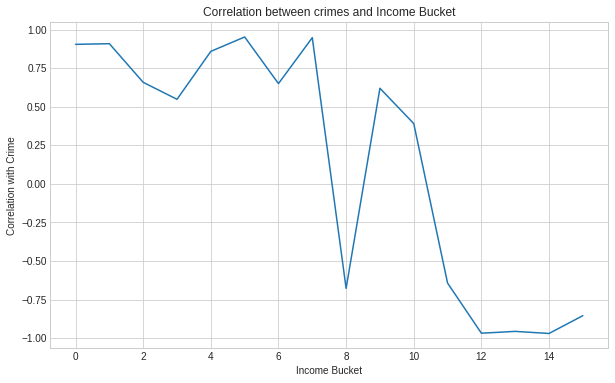

In [90]:
plt.figure(figsize=(10,6))
plt.plot(corrs_list)
plt.title("Correlation between crimes and Income Bucket")
plt.ylabel('Correlation with Crime')
plt.xlabel('Income Bucket')
plt.show()

**Inference:**
As we can see in the above plot the general trend seems to be that as income bucket increases the, the number of crimes from that section decreases. Thus we make a suggestion for increased focus on low incomes sections when it comes to policy making / patrolling etc.

In [23]:
yearwise_grouped_arrests_income.head(3)

[Row(year=2018, Case Count=53625, ID Household Income Bucket='0', Household Income Bucket='< $10,000', ID Year='2018', Year='2018', Household Income='99522', Household Income Moe='5180', Geography='Chicago, IL', ID Geography='16000US1714000', Slug Geography='chicago-il', share=0.09233072885258738),
 Row(year=2018, Case Count=53625, ID Household Income Bucket='1', Household Income Bucket='$10,000-$14,999', ID Year='2018', Year='2018', Household Income='51566', Household Income Moe='3823.9999999999995', Geography='Chicago, IL', ID Geography='16000US1714000', Slug Geography='chicago-il', share=0.04783993854637689),
 Row(year=2018, Case Count=53625, ID Household Income Bucket='2', Household Income Bucket='$15,000-$19,999', ID Year='2018', Year='2018', Household Income='51047', Household Income Moe='4430', Geography='Chicago, IL', ID Geography='16000US1714000', Slug Geography='chicago-il', share=0.047358440502984545)]

In [0]:
economically_weaker_df = yearwise_grouped_arrests_income[yearwise_grouped_arrests_income["ID Household Income Bucket"] == "0" ]
economically_weaker_new_df = economically_weaker_df.select(['Case Count', 'share'])

In [0]:
from pyspark.ml.feature import VectorAssembler
# All poor buckets share into a vector "features"
vectorAssembler = VectorAssembler(inputCols = ['share'], outputCol = 'features')
vgrouped_arrests_bucket = vectorAssembler.transform(economically_weaker_new_df)

In [36]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='Case Count',
                      maxIter=100, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(vgrouped_arrests_bucket)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

lr_predictions = lr_model.transform(vgrouped_arrests_bucket)
output = np.array(lr_predictions.select("prediction","Case Count","share").collect())

y_pred = output[:,0].reshape(-1, 1)
y = output[:, 1].reshape(-1, 1) 
X = output[:, 2].reshape(-1, 1)

coefficient_significance = slope_significance_hyp_testing(X, y, y_pred, np.array(lr_model.coefficients).reshape(-1,1))
if coefficient_significance[0] is True:
    print("Can't reject the null hupothesis that the coefficient of Income in \
NumberOfArrests prediction is insignificant. Thus Income isn't \
a good predictor of NumberOfArrests")
else:
    print("Rejecting the Null hypothesis. Thus Income is actually \
a good predictor of NumberOfArrests")
    

Coefficients: [1576667.4505695242]
Intercept: -97945.54113518544
Rejecting the Null hypothesis. Thus Income is actually a good predictor of NumberOfArrests


**Conclusion :** from the correlation graph of income bucket share and the crimes from that section, especially for the economically weaker section , we went ahead and performed hypothesis testing. We found that Income is actually a good predictor of crimes.

## Analyzing Domestic Crimes

In [37]:
domestic_df = actual_arrest_df[actual_arrest_df["Domestic"] == True]
domestic_df.head(2)

[Row(Arrest=True, Beat=923, Block='054XX S CALIFORNIA AVE', Case Number='JA377037', Community Area=63.0, Date='2011-01-01 00:01:00', Description='AGG SEX ASSLT OF CHILD FAM MBR', District=9.0, Domestic=True, FBI Code='02', ID=11042582, IUCR='1754', Latitude=None, Location=None, Location Description='APARTMENT', Longitude=None, Primary_Type_ARSON=0, Primary_Type_ASSAULT=0, Primary_Type_BATTERY=0, Primary_Type_BURGLARY=0, Primary_Type_CONCEALED CARRY LICENSE VIOLATION=0, Primary_Type_CRIM SEXUAL ASSAULT=0, Primary_Type_CRIMINAL DAMAGE=0, Primary_Type_CRIMINAL SEXUAL ASSAULT=0, Primary_Type_CRIMINAL TRESPASS=0, Primary_Type_DECEPTIVE PRACTICE=0, Primary_Type_DOMESTIC VIOLENCE=0, Primary_Type_GAMBLING=0, Primary_Type_HOMICIDE=0, Primary_Type_HUMAN TRAFFICKING=0, Primary_Type_INTERFERENCE WITH PUBLIC OFFICER=0, Primary_Type_INTIMIDATION=0, Primary_Type_KIDNAPPING=0, Primary_Type_LIQUOR LAW VIOLATION=0, Primary_Type_MOTOR VEHICLE THEFT=0, Primary_Type_NARCOTICS=0, Primary_Type_NON - CRIMINAL

In [0]:
# group by year
domestic_grouped_arrests = domestic_df.groupBy([F.year('Date').alias('year')]).\
          agg(F.count('Arrest').alias('Case Count'))
# join with income data
domestic_grouped_arrests_income = domestic_grouped_arrests.join(income_df, (domestic_grouped_arrests.year ==\
                        income_df.Year))
# checking the domestic crimes amongst economically weaker section
domestic_bucket_df = domestic_grouped_arrests_income[domestic_grouped_arrests_income["ID Household Income Bucket"] == "0" ]
domestic_bucket_new_df = domestic_bucket_df.select(['Case Count', 'share'])

In [45]:
domestic_bucket_new_df.head(2)

[Row(Case Count=7640, share=0.09233072885258738),
 Row(Case Count=8640, share=0.10429260872991533)]

In [0]:
corrs_list = []
for bucket in range(0,16,3):
  bucket = str(bucket)
  domestic_bucket_df = domestic_grouped_arrests_income[domestic_grouped_arrests_income["ID Household Income Bucket"] == bucket ]
  domestic_bucket_new_df = domestic_bucket_df.select(['Case Count', 'share'])
  corr = domestic_bucket_new_df.corr('Case Count', 'share')
  corrs_list.append(corr)

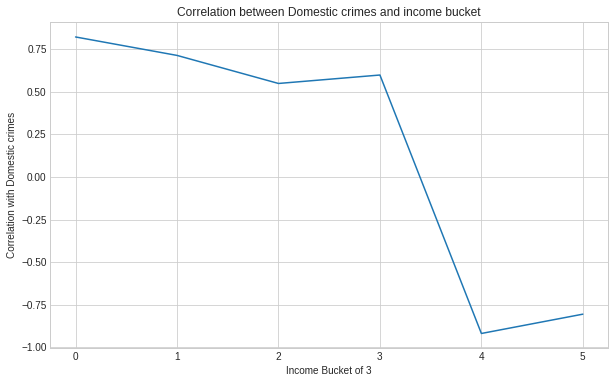

In [88]:
plt.figure(figsize=(10,6))
plt.plot(corrs_list)
plt.title("Correlation between Domestic crimes and income bucket")
plt.ylabel('Correlation with Domestic crimes')
plt.xlabel('Income Bucket of 3')
plt.show()

**Inference:** As we can see in the above plot the general trend seems to be that as income bucket increases , the number of Domestic crimes from that section decreases. Thus we make a suggestion for increased focus on low incomes sections when it comes to councelling / mental health support etc.

# Analysis of different types of crimes for low and high income buckets

In [0]:
low_income_bucket = []
high_income_bucket = []
actual_arrest_df = actual_arrest_df.withColumn('IUCR', actual_arrest_df['IUCR'].cast(IntegerType()))
#homicide = 110 - 142
#sexual_assault = 261 - 291
#gambling 1610 - 1697
#[110,142]
crimes = [[261,291],[1610,1697]]
for crime in crimes:
  start_iucr,end_iucr = crime
  s_df = actual_arrest_df.filter(actual_arrest_df.IUCR >= start_iucr)
  crime_df = s_df.filter(s_df.IUCR <= end_iucr)

  # group by year
  crime_grouped_df = crime_df.groupBy([F.year('Date').alias('year')]).\
  agg(F.count('Arrest').alias('Case Count'))
  
  # join with income data
  crime_grouped_arrests_income = crime_grouped_df.join(income_df, (crime_grouped_df.year ==\
                        income_df.Year))
  
  # checking the crimes for the buckets
  crime_bucket_df = crime_grouped_arrests_income[crime_grouped_arrests_income["ID Household Income Bucket"] == "0" ]
  crime_bucket_new_df = crime_bucket_df.select(['Case Count', 'share'])
  low_income_bucket.append(crime_bucket_new_df.corr('Case Count', 'share'))

  crime_bucket_df = crime_grouped_arrests_income[crime_grouped_arrests_income["ID Household Income Bucket"] == "15" ]
  crime_bucket_new_df = crime_bucket_df.select(['Case Count', 'share'])
  high_income_bucket.append(crime_bucket_new_df.corr('Case Count', 'share'))





In [82]:
# correlation for low income bucket for homicide, sexual_assault and gambling
low_income_bucket

[-0.3437399425196877, 0.938302091074459, 0.9155651411138681]

In [83]:
# correlation for high income bucket for homicide, sexual_assault and gambling
high_income_bucket

[0.3557221614229609, -0.803535711603009, -0.7871895534987005]

**Inference Drawn:**

1.   There are slighlty more homicide cases in buckets with high income.
2.   There seem to be more cases of sexual assault and gambling related cases in low income buckets (Maybe high income people indulge in legal gambling ?)

## Housing Related Data

In [46]:
# Get chicago Housing data
housing_df = spark.read.csv('/content/drive/My Drive/Chicago_Housing.csv',header=True)
housing_df.head(2)

[Row(ID='2530006', PERMIT#='100523607', PERMIT_TYPE='PERMIT - SIGNS', REVIEW_TYPE='SIGN PERMIT', APPLICATION_START_DATE='02/24/2014', ISSUE_DATE='03/04/2014', PROCESSING_TIME='8', STREET_NUMBER='10000', STREET DIRECTION='W', STREET_NAME='OHARE', SUFFIX='ST', WORK_DESCRIPTION='TERMINAL 1 - BLADE SIGN', BUILDING_FEE_PAID='100.00', ZONING_FEE_PAID='200.00', OTHER_FEE_PAID='0.00', SUBTOTAL_PAID='300.00', BUILDING_FEE_UNPAID='0.00', ZONING_FEE_UNPAID='0.00', OTHER_FEE_UNPAID='0.00', SUBTOTAL_UNPAID='0.00', BUILDING_FEE_WAIVED='0.00', ZONING_FEE_WAIVED='0.00', OTHER_FEE_WAIVED='0.00', SUBTOTAL_WAIVED='0.00', TOTAL_FEE='300.00', CONTACT_1_TYPE='SIGN CONTRACTOR', CONTACT_1_NAME='J & S ELECTRIC', CONTACT_1_CITY='AURORA', CONTACT_1_STATE='IL', CONTACT_1_ZIPCODE='60505-', CONTACT_2_TYPE=None, CONTACT_2_NAME=None, CONTACT_2_CITY=None, CONTACT_2_STATE=None, CONTACT_2_ZIPCODE=None, CONTACT_3_TYPE=None, CONTACT_3_NAME=None, CONTACT_3_CITY=None, CONTACT_3_STATE=None, CONTACT_3_ZIPCODE=None, CONTACT_4_

In [47]:
# Get data for new constructions only
new_housing_df = housing_df[housing_df["PERMIT_TYPE"] == "PERMIT - NEW CONSTRUCTION"] 
new_housing_df.head(3)

[Row(ID='1709324', PERMIT#='100130631', PERMIT_TYPE='PERMIT - NEW CONSTRUCTION', REVIEW_TYPE='STANDARD PLAN REVIEW', APPLICATION_START_DATE='08/11/2006', ISSUE_DATE='08/14/2006', PROCESSING_TIME='3', STREET_NUMBER='500', STREET DIRECTION='S', STREET_NAME='LAKE SHORE', SUFFIX='DR', WORK_DESCRIPTION="PERMIT EXPIRES ON 10/14/2006 Erect a 30' x 30' canopy for event August 12,2006 with setup 8/11/06 and takedown 8/12/06 per plans.                                                                                                              -CONDITIONAL PERMIT, SUBJECT TO FIELD VERIFICATION.", BUILDING_FEE_PAID='125.00', ZONING_FEE_PAID='75.00', OTHER_FEE_PAID='0.00', SUBTOTAL_PAID='200.00', BUILDING_FEE_UNPAID='0.00', ZONING_FEE_UNPAID='0.00', OTHER_FEE_UNPAID='0.00', SUBTOTAL_UNPAID='0.00', BUILDING_FEE_WAIVED='0.00', ZONING_FEE_WAIVED='0.00', OTHER_FEE_WAIVED='0.00', SUBTOTAL_WAIVED='0.00', TOTAL_FEE='200.00', CONTACT_1_TYPE='TENT CONTRACTOR', CONTACT_1_NAME='PHOENIX EVENT SERVICES LLC DBA'

In [0]:
# Type cast reported cost of the new construction
new_housing_df = new_housing_df.withColumn('REPORTED_COST', new_housing_df['REPORTED_COST'].cast(DoubleType()))
# group by community area and get the mean of the new construction. This acts as a proxy for how good a locality this is.
area_cost_df = new_housing_df.groupBy("COMMUNITY_AREA").agg(F.mean('REPORTED_COST'))
# get crimes per community area
area_grouped_arrests = actual_arrest_df.groupBy("Community Area").agg(F.count('Arrest').alias('Case Count'))

In [49]:
# join the comm
grouped_area_arrests_cost = area_grouped_arrests.join(area_cost_df, (area_grouped_arrests["Community Area"]==\
                        area_cost_df["COMMUNITY_AREA"]))

grouped_area_arrests_cost.corr('Case Count', 'avg(REPORTED_COST)')

0.0011719866846330166

In [50]:
actual_arrest_df = actual_arrest_df.withColumn('IUCR', actual_arrest_df['IUCR'].cast(IntegerType()))
theft_df = actual_arrest_df.filter(actual_arrest_df.IUCR > 610)
theft_and_burglary_df = theft_df.filter(theft_df.IUCR < 895)
theft_and_burglary_areagrouped_df = theft_and_burglary_df.groupBy("Community Area").agg(F.count('Arrest').alias('theft burglary Count'))
theft_and_burglary_areagrouped_df.head(2)

[Row(Community Area=8.0, theft burglary Count=13894),
 Row(Community Area=67.0, theft burglary Count=2496)]

In [52]:
grouped_area_arrests_cost = theft_and_burglary_areagrouped_df.join(area_cost_df, (theft_and_burglary_areagrouped_df["Community Area"]==\
                        area_cost_df["COMMUNITY_AREA"]))
grouped_area_arrests_cost.corr('theft burglary Count', 'avg(REPORTED_COST)')

0.29910155784291703

**Inference :** From the above we can see that there is a correlation of almost 0 between the average price of a property in a community area and the total crimes in that area. Thus all community areas are almost equally Susceptible to crimes.

However if we just look at crimes related to burglary and theft we see a correlation of almost 0.3, meaning community areas that are richer are more Susceptible to theft and burglary. Thus we would make a suggestion of taking steps that particularly prevent theft and burglary in such area like CCTV surveillance etc.